In [376]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import osmnx as ox

from shapely.geometry import Point
import geopandas as gpd

# Tworzenie grafu

In [377]:
routes_df = pd.read_csv("routes_df.csv")

In [378]:
G = nx.from_pandas_edgelist(routes_df, edge_attr='time', create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(routes_df, edge_attr='time', create_using=nx.DiGraph())
G3 = nx.Graph(G2)
# pos_fruchterman_reingold = nx.fruchterman_reingold_layout(G3)
# pos_kamada_kawai = nx.kamada_kawai_layout(G3)

In [379]:
locations = pd.read_csv('stops.txt', sep=",", header=0)
locations['name_code_merge'] = locations.stop_name + '-' + locations.stop_code.astype(str)
locations.drop(['stop_name', 'stop_code', 'stop_id'], axis=1, inplace=True)
set(routes_df.source.unique().tolist()) - set(locations.name_code_merge.unique().tolist())

set()

In [380]:
locations.drop_duplicates(inplace=True)
# locations.to_csv('locations_geo.csv', index=False)
locations.head()

stop_lat   stop_lon                    name_code_merge
0  51.133826  16.956735                   Metalowców-12525
1  51.094301  17.032229                   Dyrekcyjna-21101
2  51.112567  16.994232  Wrocławski Park Przemysłowy-12102
3  51.112189  17.063358              PL. GRUNWALDZKI-20923
4  51.152213  17.070059                     Bagatela-23724

In [381]:
# Google Colab magic

In [382]:
locations.drop_duplicates(inplace=True)
locations = pd.read_csv('locations_xy.csv', sep=",", header=0)
locations

name_code_merge             x             y
0                      Metalowców-12525  1.887615e+06  6.611710e+06
1                      Dyrekcyjna-21101  1.896019e+06  6.604720e+06
2     Wrocławski Park Przemysłowy-12102  1.891789e+06  6.607950e+06
3                 PL. GRUNWALDZKI-20923  1.899484e+06  6.607883e+06
4                        Bagatela-23724  1.900230e+06  6.614964e+06
...                                 ...           ...           ...
2281                  Gospodarska-24729  1.906097e+06  6.609004e+06
2282                      Grabowa-38104  1.883660e+06  6.612778e+06
2283                Hala Stulecia-42533  1.900584e+06  6.607022e+06
2284           Piwnika - Ponurego-29513  1.904802e+06  6.614495e+06
2285           Piwnika - Ponurego-29514  1.904662e+06  6.614632e+06

[2286 rows x 3 columns]

In [4]:
n_G_edges, n_G2_edges = len(G.edges), len(G2.edges)
print(f"Przed usunięciem pętli i wielokrotnych krawędzi: {n_G_edges}")
print(f"Po usunięciu pętli i wielokrotnych krawędzi: {n_G2_edges}")
print(f"Ubyło {n_G_edges - n_G2_edges} krawędzi (pozostało {n_G2_edges/n_G_edges*100:.2f}% krawędzi)")

Przed usunięciem pętli i wielokrotnych krawędzi: 6204
Po usunięciu pętli i wielokrotnych krawędzi: 2643
Ubyło 3561 krawędzi (pozostało 42.60% krawędzi)


In [5]:
n_G3_edges = len(G3.edges)
print(f"Przed usunięciem kierunków i redukcji wielokrotnych ścieżek: {n_G2_edges}")
print(f"Po usunięciu pętli i wielokrotnych krawędzi: {n_G3_edges}")
print(f"Ubyło {n_G2_edges - n_G3_edges} krawędzi (pozostało {n_G3_edges/n_G2_edges*100:.2f}% krawędzi)")

Przed usunięciem kierunków i redukcji wielokrotnych ścieżek: 2643
Po usunięciu pętli i wielokrotnych krawędzi: 2640
Ubyło 3 krawędzi (pozostało 99.89% krawędzi)


# Analiza sieci

* liczba wierzchołków/krawędzi
* rozkład stopni węzła
* rozkład najkrótszych ścieżek
* rozkład współczynnika grupowania
* średnica sieci
* liczba komponentów
* kluczowe węzły w sieci z punktu widzenia różnych miar
* do jakiego modelu sieci jest zbliżona nasza sieć (losowa, bezskalowa itd.)

## Liczba wierzchołków/krawędzi

In [ ]:
G3.number_of_nodes(), G3.number_of_edges()

(2062, 2640)

## Rozkład stopni węzła

(array([1.342e+03, 4.400e+02, 1.700e+02, 5.700e+01, 2.700e+01, 9.000e+00,
        9.000e+00, 5.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

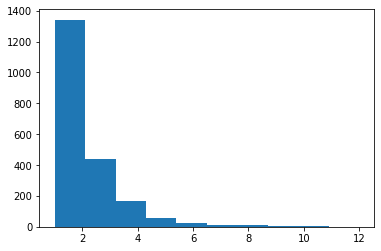

In [16]:
degrees = np.array([G3.degree(node) for node in G2.nodes])
plt.hist(degrees, bins=10)

## Rozkład najkrótszych ścieżek

In [28]:
path_lengths = [list(x[1].values()) for x in list(nx.shortest_path_length(G3))]
path_lengths = [x for xs in path_lengths for x in xs]
sns.histplot(path_lengths, bins=20)

## Rozkład współczynnika grupowania sieci

<AxesSubplot:ylabel='Count'>

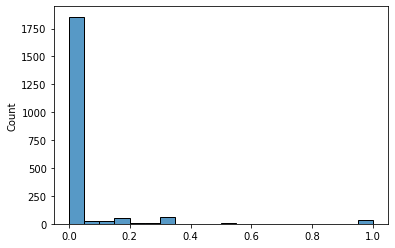

In [32]:
sns.histplot(list(nx.clustering(G3).values()), bins=20)

# Wizualizacje rozkładów

In [383]:
wroc = ox.geocode_to_gdf("Wrocław, Poland")
wroc.to_crs(crs='EPSG:3395', inplace=True)

## tworzenie wierzchołków

In [398]:
graph_nodes = pd.DataFrame.from_dict({
    "name_code_merge": list(G3.nodes),
    "degree": np.array([G3.degree(node) for node in G2.nodes]),
    "mean_shortest_path_length": [np.mean(list(x[1].values())) for x in list(nx.shortest_path_length(G3))],
    "clustering_coef": list(nx.clustering(G3).values()),
    "betweenness_centrality": list(nx.betweenness_centrality(G3).values())
})

graph_nodes_df = graph_nodes.merge(locations, on='name_code_merge')
graph_nodes_df['geometry'] = graph_nodes_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
graph_nodes_gdf = gpd.GeoDataFrame(graph_nodes_df, crs='EPSG:3395')

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## tworzenie krawędzi

In [385]:
from shapely.geometry import LineString

edge_rows = []

for row in routes_df.drop_duplicates(['source', 'target']).iterrows():
    row = row[1]
    source = row['source']
    target = row['target']
    source_geometry = graph_nodes_gdf[graph_nodes_gdf['name_code_merge'] == source]['geometry'].values[0]
    target_geometry = graph_nodes_gdf[graph_nodes_gdf['name_code_merge'] == target]['geometry'].values[0]
    edge_row = {
        'source': source,
        'target': target,
        'source_geometry': source_geometry,
        'target_geometry': target_geometry,
        'geometry': LineString([source_geometry.coords[0], target_geometry.coords[0]]),
        'u': source,
        'v': target,
        'key': 0
    }
    edge_rows.append(edge_row)

graph_edges_gdf = gpd.GeoDataFrame.from_dict(edge_rows, crs='EPSG:3395').set_index(['u', 'v', 'key'])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


## Wizualizacje

In [386]:
params = {
    "degree": {"multiplier": 35, "asc": False},
    "mean_shortest_path_length": {"multiplier": 4, "asc": True},
    "clustering_coef": {"multiplier": 150, "asc": False},
    "betweenness_centrality": {"multiplier": 2000, "asc": False}
}

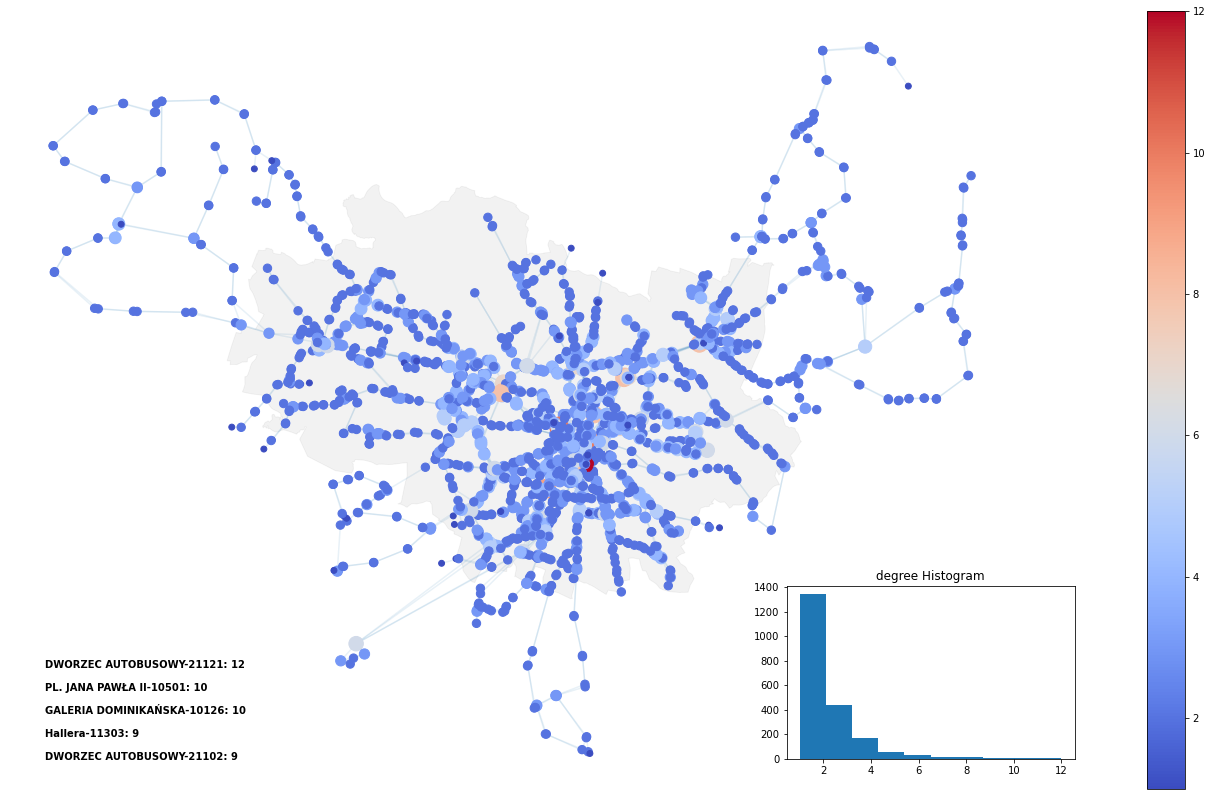

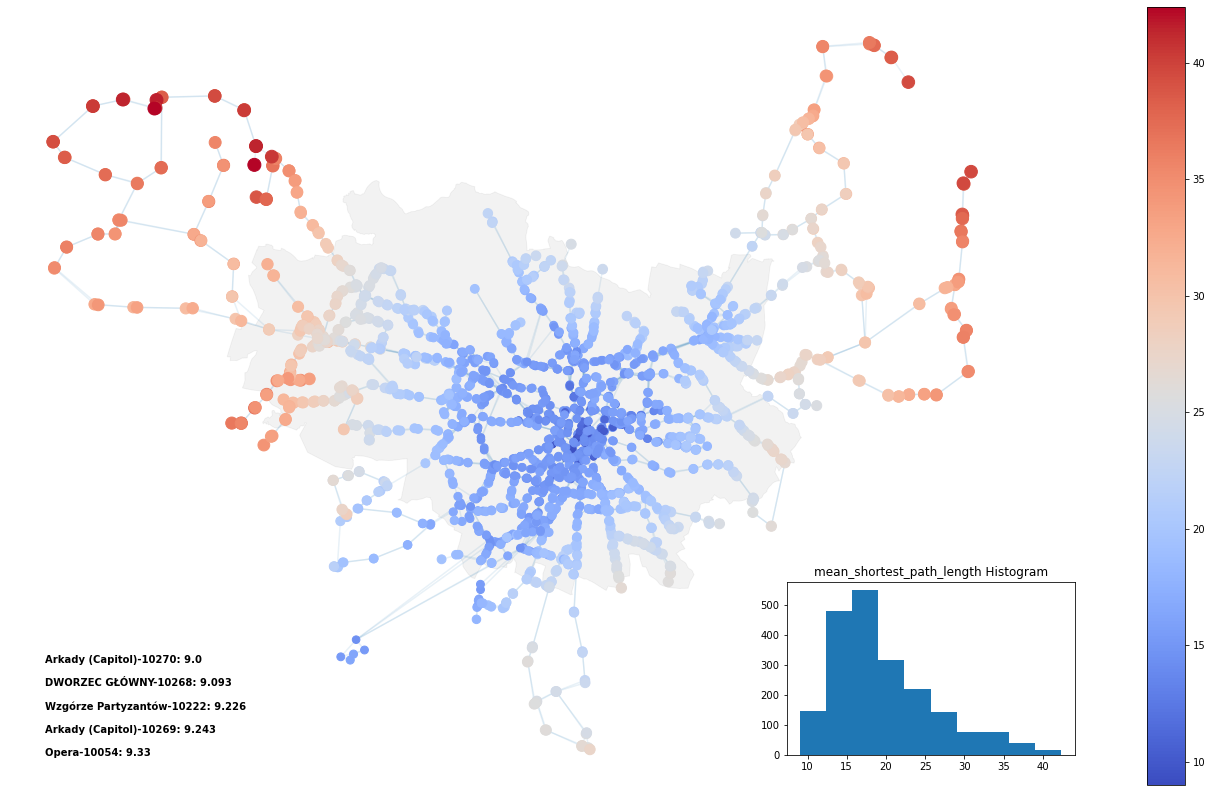

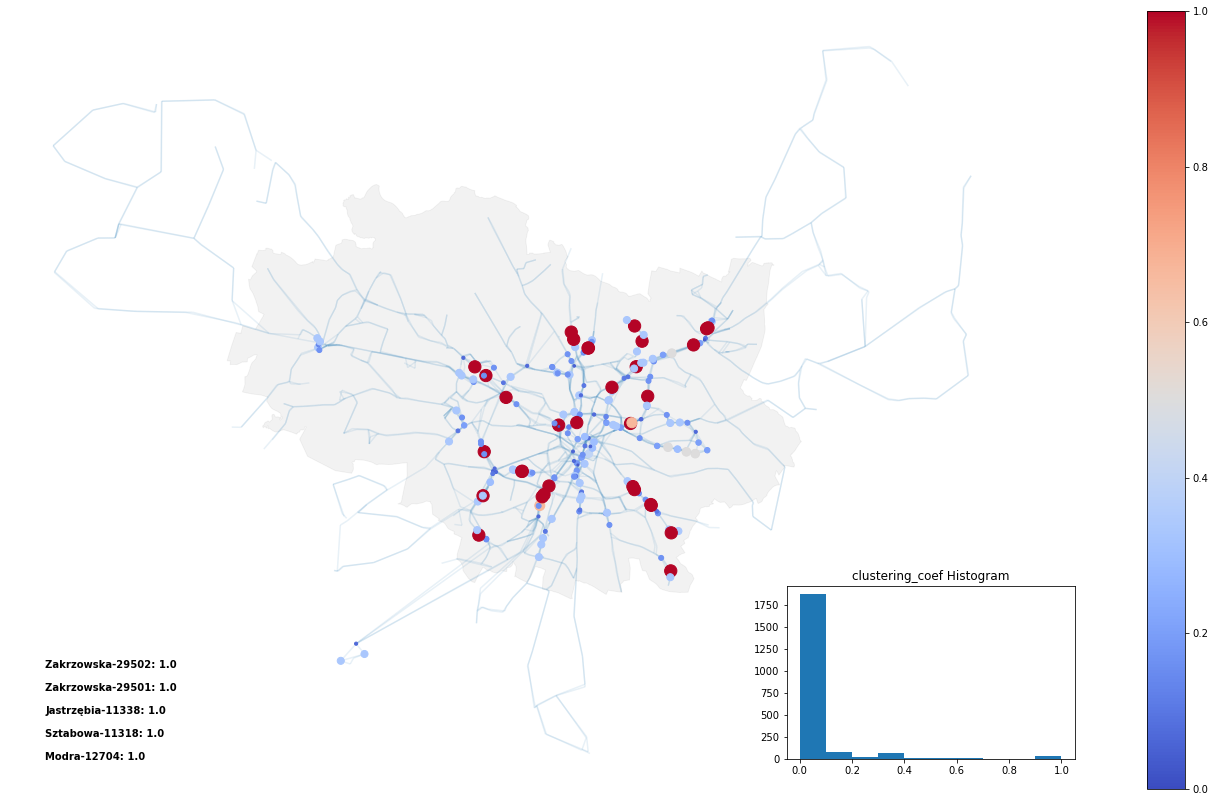

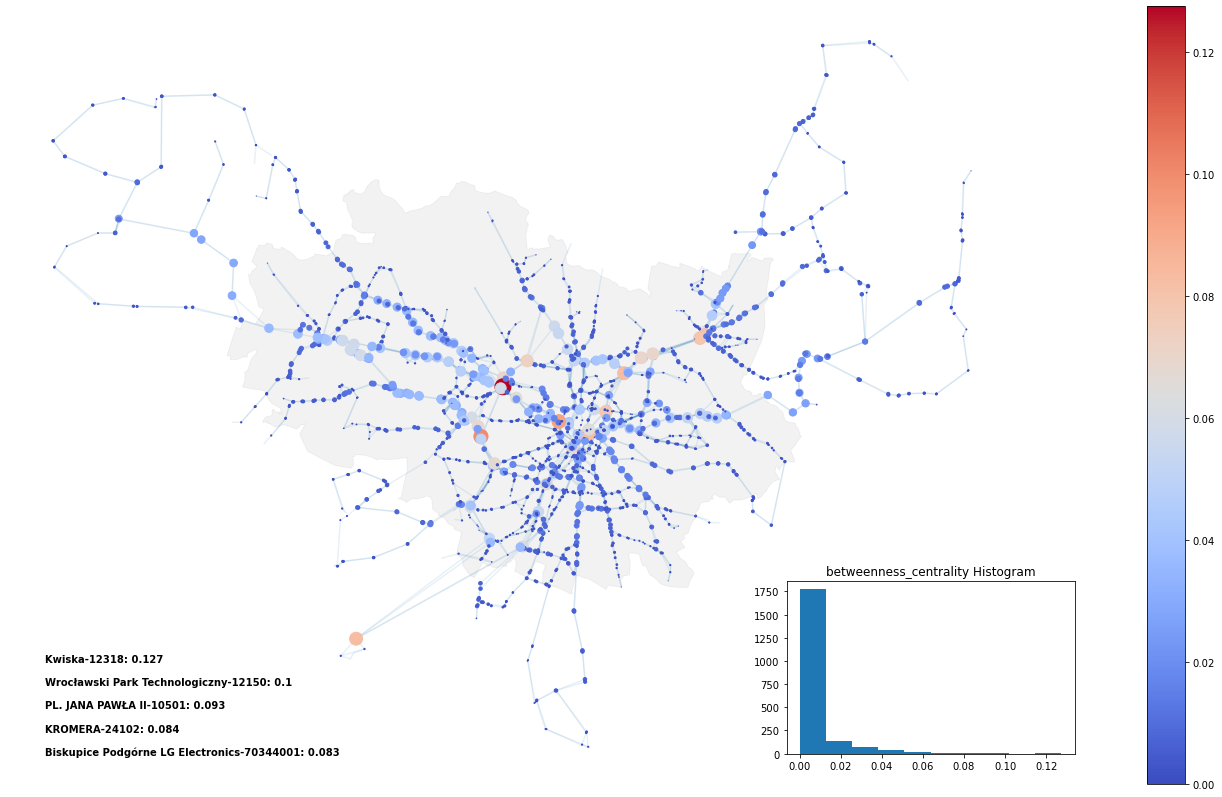

In [375]:
for metric in params.keys():
    asc = params[metric]['asc']
    multiplier = params[metric]['multiplier']

    fig = plt.figure(figsize=(40, 12))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    ax2 = fig.add_axes([0.74, 0.135, 0.1, 0.2])

    values = graph_nodes_gdf[metric].values
    ax2.hist(values, bins=10)
    ax2.set_title(f"{metric} Histogram")

    five_best = graph_nodes_gdf.sort_values(by=metric, ascending=asc).iloc[:5][['name_code_merge', metric]].values
    five_best[:, 1] = [str(round(el, 3)) for el in five_best[:, 1]]
    five_best[:, 0] = [f"{el}" for el in five_best[:, 0]]
    info = "\n\n".join([": ".join(el) for el in five_best])
    ax.text(1.858e6, 6.584e6, info, fontweight="bold")


    markersize = values * multiplier
    graph_nodes_gdf.plot(ax=ax, column=metric, legend=True, alpha=1, markersize=markersize, cmap='coolwarm', zorder=3)
    graph_edges_gdf.plot(ax=ax, alpha=0.1, zorder=2)
    wroc.plot(ax=ax, alpha=0.05, edgecolor='black', color='black', zorder=1)

    ax.axis('off')
    plt.savefig(f"plots/{metric}.svg")

# Analiza grup

In [388]:
from tqdm.notebook import tqdm
from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict

def agglomerative_grouping(G):
    nodes = list(G.nodes())
    path_length = nx.all_pairs_shortest_path_length(G)
    path_length = [path for path in path_length]
    # Set-up the distance matrix D
    distances = np.zeros((len(G),len(G)))   
    for u, p in tqdm(path_length, total=len(path_length)):
        for v, d in p.items():
            distances[nodes.index(u)][nodes.index(v)] = d
            distances[nodes.index(v)][nodes.index(u)] = d
            if u == v: 
                distances[nodes.index(u)][nodes.index(u)] = 0
    Y = distance.squareform(distances) # the upper triangular of the distance matrix 
    Z = hierarchy.average(Y)        
    return Z

In [389]:
Z = agglomerative_grouping(G3) 

  0%|          | 0/2062 [00:00<?, ?it/s]

In [452]:
groups_gdf = graph_nodes.merge(locations, on='name_code_merge').drop_duplicates('name_code_merge')

for n_groups in [5, 10, 15, 20]:
    groups = hierarchy.fcluster(Z, criterion='maxclust', t=n_groups)
    groups_gdf[f'{n_groups}_groups'] = groups
    
groups_gdf = gpd.GeoDataFrame(groups_gdf)
groups_gdf['geometry'] = groups_gdf.apply(lambda row: Point(row['x'], row['y']), axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


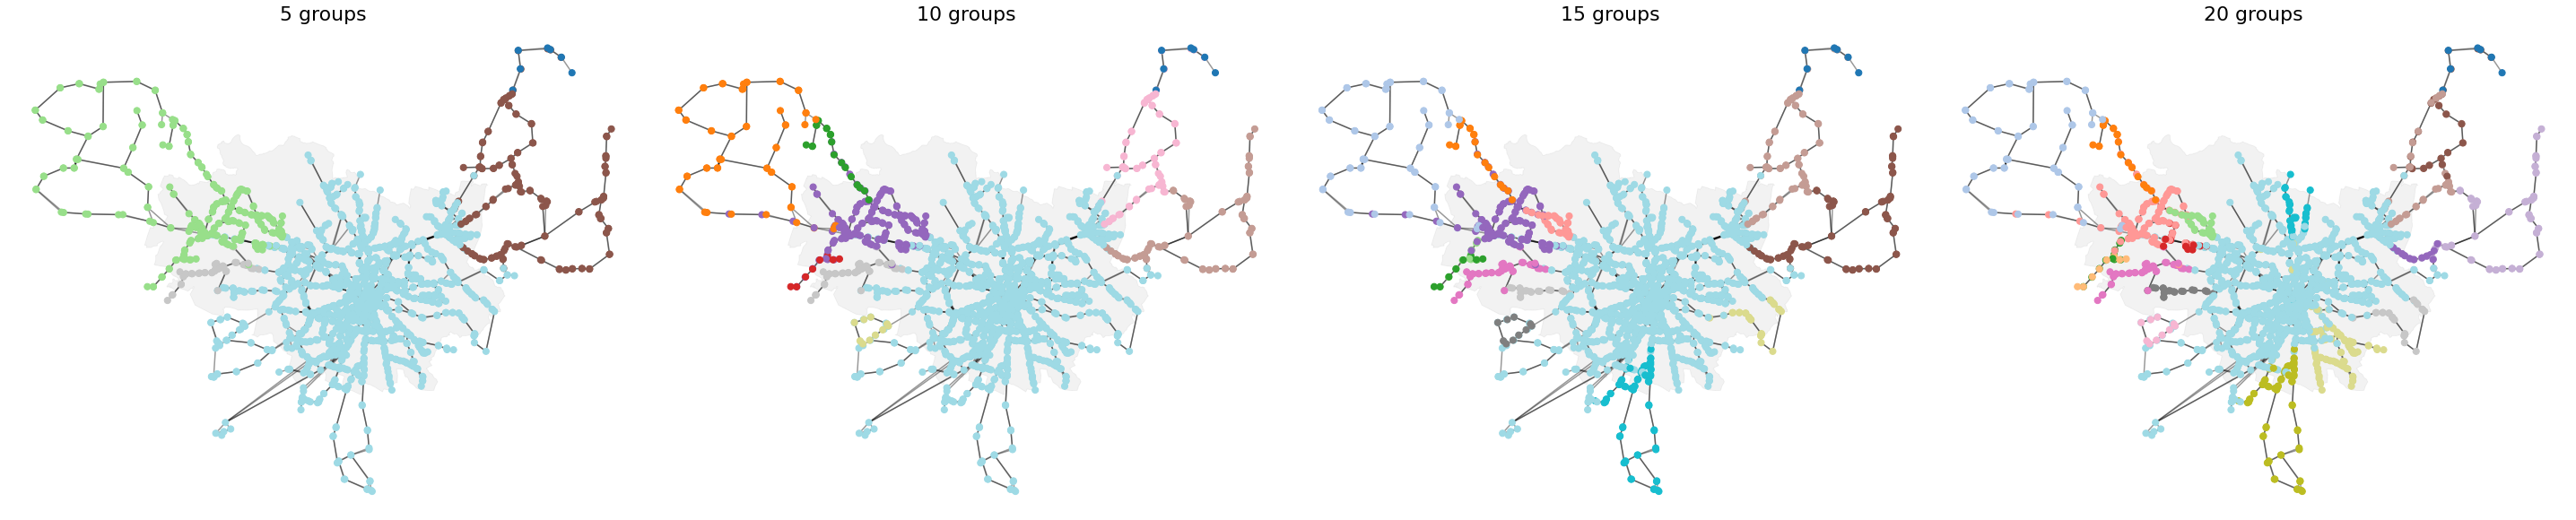

In [464]:
fig, axes = plt.subplots(1, 4, figsize=(40, 20))

for n_groups, ax in zip([5, 10, 15, 20], axes): 
    groups_gdf.plot(ax=ax, column=f'{n_groups}_groups', cmap='tab20', alpha=1, markersize=50, zorder=3)
    graph_edges_gdf.plot(ax=ax, alpha=0.4, color='black', zorder=2)
    wroc.plot(ax=ax, alpha=0.05, edgecolor='black', color='black', zorder=1)
    ax.set_title(f"{n_groups} groups", fontsize=22)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f"plots/group_analysis.svg")

## Liczba komponentów

In [35]:
print('komponenty silnie połączone:', len(list(nx.strongly_connected_components(G2))))
print('komponenty słabo połączone:', len(list(nx.weakly_connected_components(G2))))

komponenty silnie połączone: 313
komponenty słabo połączone: 2


## Kluczowe węzły w sieci z punktu widzenia różnych miar

### Bliskość

In [36]:
d = nx.closeness_centrality(G2)
sorted_closeness_centrality =  sorted(d, key=d.get, reverse=True)[:10]
pd.Series({k: round(d[k], 4) for k in sorted_closeness_centrality})

GALERIA DOMINIKAŃSKA-10111    0.0459
GALERIA DOMINIKAŃSKA-10126    0.0458
skwer Krasińskiego-20337      0.0457
PL. JANA PAWŁA II-10501       0.0453
DWORZEC AUTOBUSOWY-11321      0.0451
Katedra-20909                 0.0446
Dyrekcyjna-21101              0.0442
Ogród Botaniczny-20903        0.0442
PL. GRUNWALDZKI-20916         0.0440
Katedra-20931                 0.0438
dtype: float64

### Stopień

In [37]:
d = dict(nx.degree(G2))
sorted_degree =  sorted(d, key=d.get, reverse=True)[:10]
pd.Series({k: round(d[k], 4) for k in sorted_degree})

DWORZEC AUTOBUSOWY-21121                     12
GALERIA DOMINIKAŃSKA-10126                   10
PL. JANA PAWŁA II-10501                      10
Arkady (Capitol)-10366                        9
Hallera-11304                                 9
GALERIA DOMINIKAŃSKA-10111                    9
Psie Pole (Rondo Lotników Polskich)-29128     9
Hallera-11303                                 9
DWORZEC AUTOBUSOWY-21102                      9
KROMERA-24112                                 8
dtype: int64

### Betweenness centrality

In [38]:
d = nx.betweenness_centrality(G2)
sorted_betweenness =  sorted(d, key=d.get, reverse=True)[:10]
pd.Series({k: round(d[k], 4) for k in sorted_betweenness})

Kwiska-12318                                  0.1005
Wejherowska-12315                             0.1004
GALERIA DOMINIKAŃSKA-10126                    0.0867
FAT-11707                                     0.0716
Wrocławski Park Technologiczny-12150          0.0716
Psie Pole-29103                               0.0691
Psie Pole (Rondo Lotników Polskich)-29128     0.0647
GALERIA DOMINIKAŃSKA-10111                    0.0632
Biskupice Podgórne LG Electronics-70344001    0.0626
Arkady (Capitol)-10365                        0.0625
dtype: float64

## Do jakiego modelu sieci jest zbliżona nasza sieć (losowa, bezskalowa itd.)

### Metryki dla naszej sieci

In [40]:
from graph_tiger.measures import run_measure

# 2062, 2640 in our data
print(f'Number of edges: {G3.number_of_edges()}')

avg_vertex_betweenness = run_measure(G3, measure='average_vertex_betweenness')
print("Average vertex betweenness:", avg_vertex_betweenness)

Number of edges: 2640
Average vertex betweenness: 16093.68


### Porównanie z Erdos-Renyi

In [47]:
from graph_tiger.graphs import erdos_reyni

temp_graph = erdos_reyni(n=2062, p=0.0012, seed=None)
print(f'Number of edges: {temp_graph.number_of_edges()}')

avg_vertex_betweenness = run_measure(temp_graph, measure='average_vertex_betweenness')
print("Average vertex betweenness:", avg_vertex_betweenness)

Number of edges: 2621
Average vertex betweenness: 7317.11


### Porównanie z Barabasi-Albert

In [50]:
from graph_tiger.graphs import barabasi_albert

temp_graph = barabasi_albert(n=2062, m=2, seed=None)
print(f'Number of edges: {temp_graph.number_of_edges()}')

avg_vertex_betweenness = run_measure(temp_graph, measure='average_vertex_betweenness')
print("Average vertex betweenness:", avg_vertex_betweenness)

Number of edges: 4120
Average vertex betweenness: 5592.29


In [51]:
from graph_tiger.graphs import barabasi_albert

temp_graph = barabasi_albert(n=2062, m=1, seed=None)
print(f'Number of edges: {temp_graph.number_of_edges()}')

avg_vertex_betweenness = run_measure(temp_graph, measure='average_vertex_betweenness')
print("Average vertex betweenness:", avg_vertex_betweenness)

Number of edges: 2061
Average vertex betweenness: 8484.74


In [67]:
from graph_tiger.graphs import clustered_scale_free

temp_graph = clustered_scale_free(n=2062, m=1, p=0.05, seed=None)
print(f'Number of edges: {temp_graph.number_of_edges()}')

avg_vertex_betweenness = run_measure(temp_graph, measure='average_vertex_betweenness')
print("Average vertex betweenness:", avg_vertex_betweenness)

Number of edges: 2061
Average vertex betweenness: 9251.89


# Wizualizacje

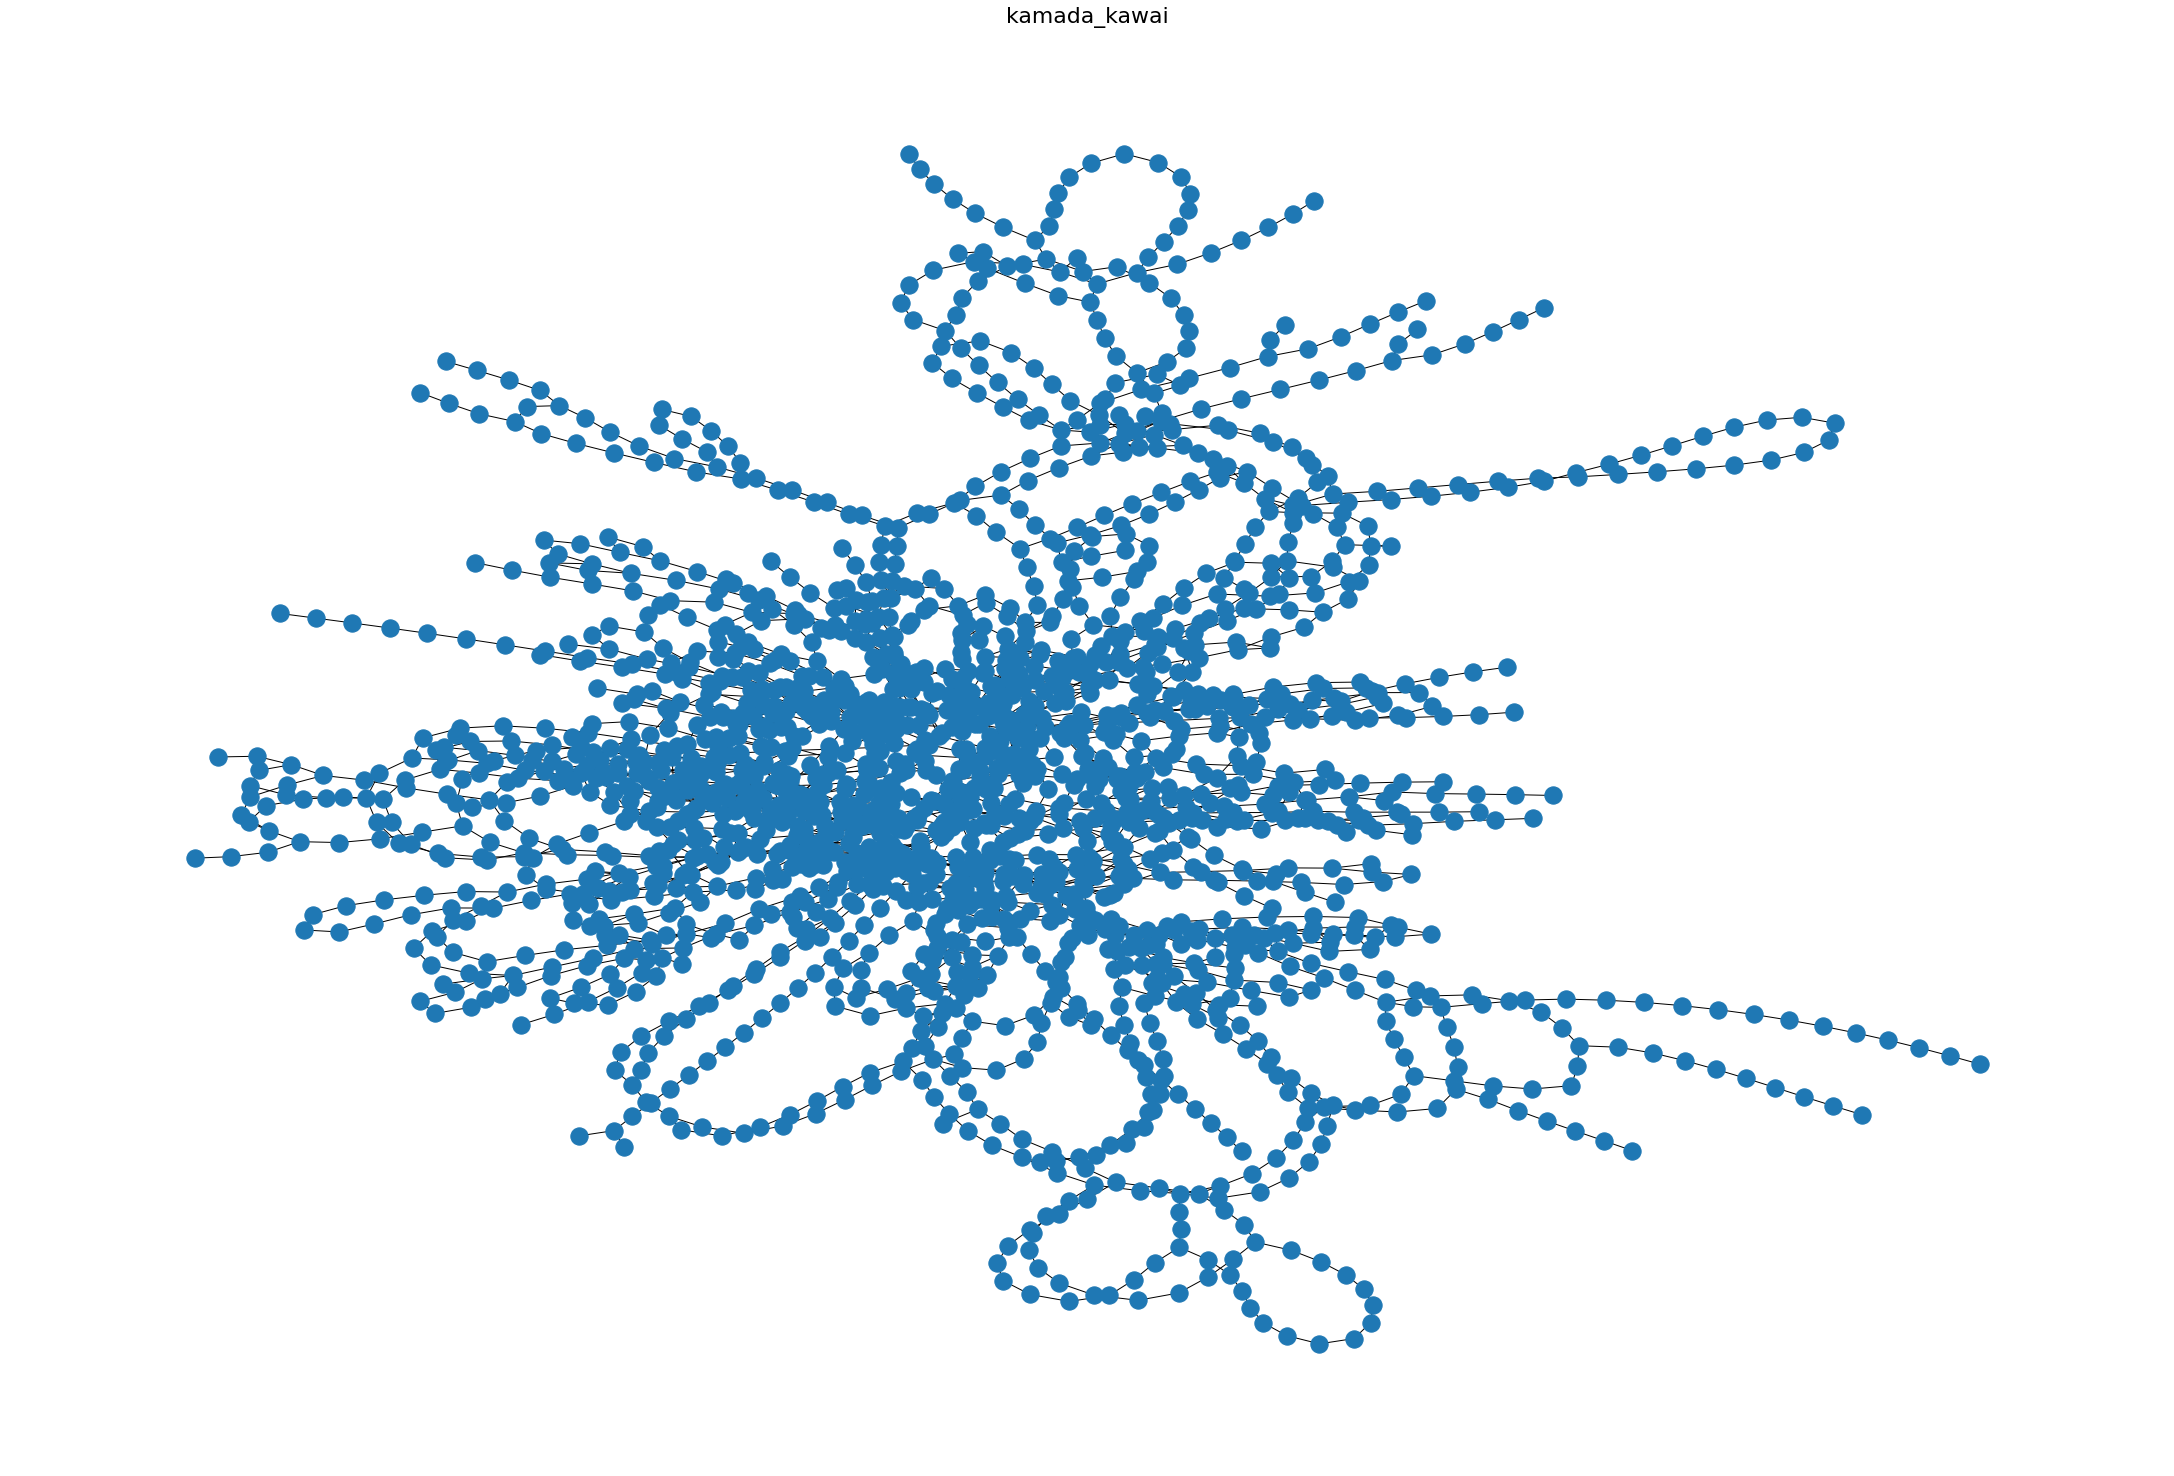

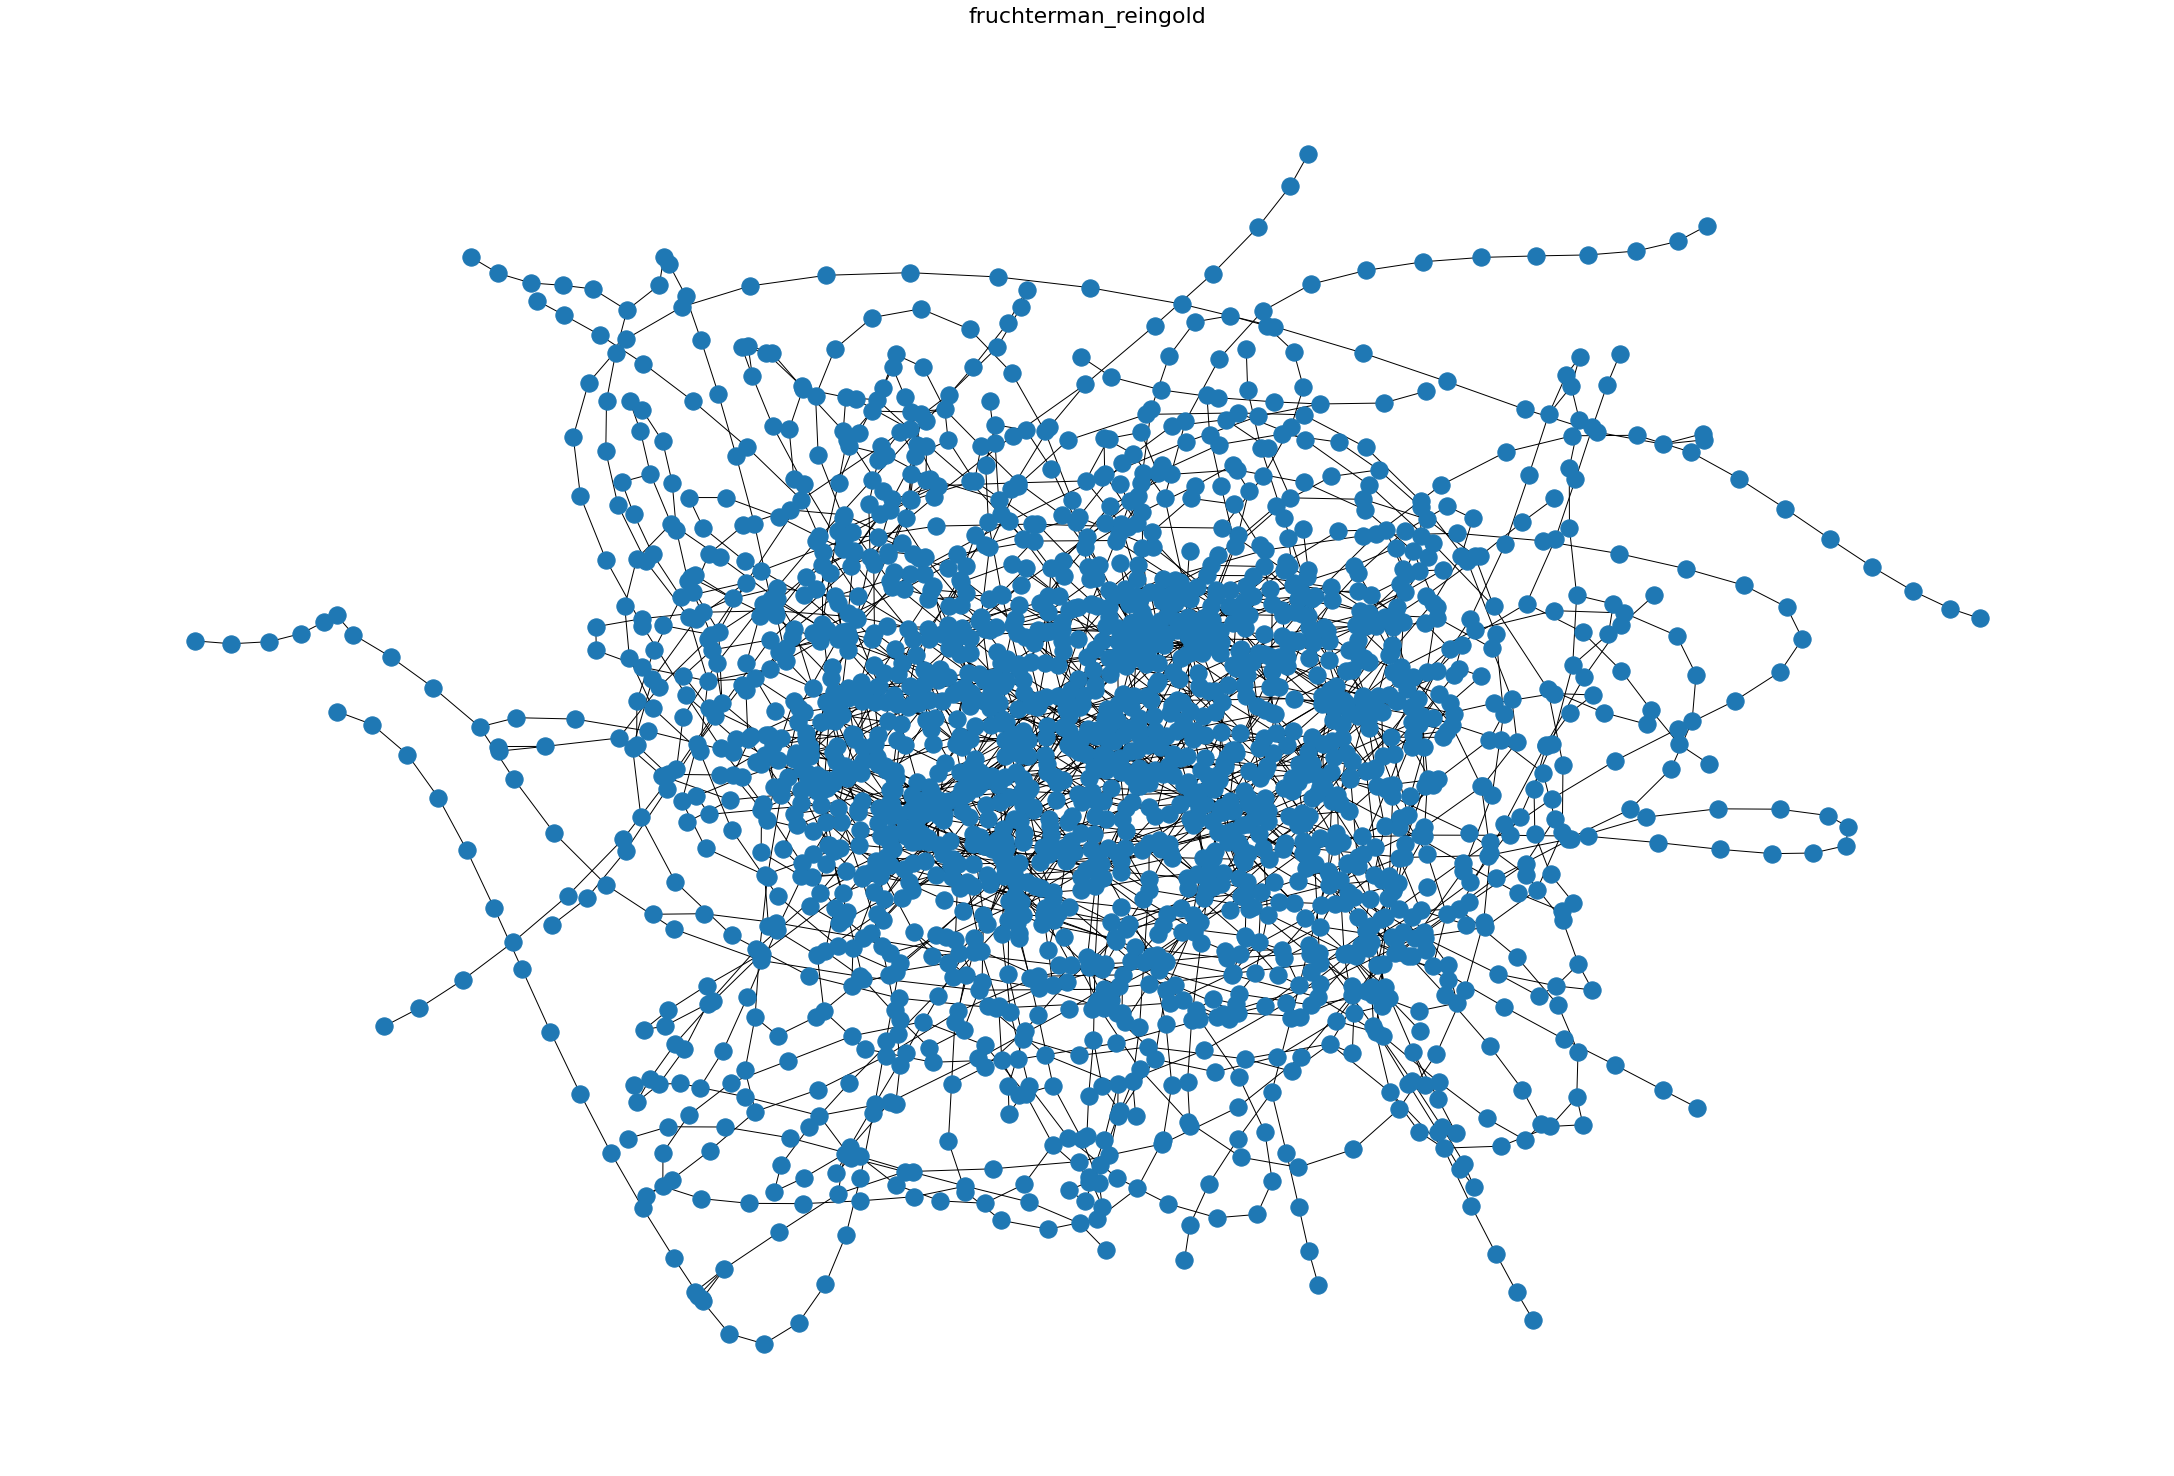

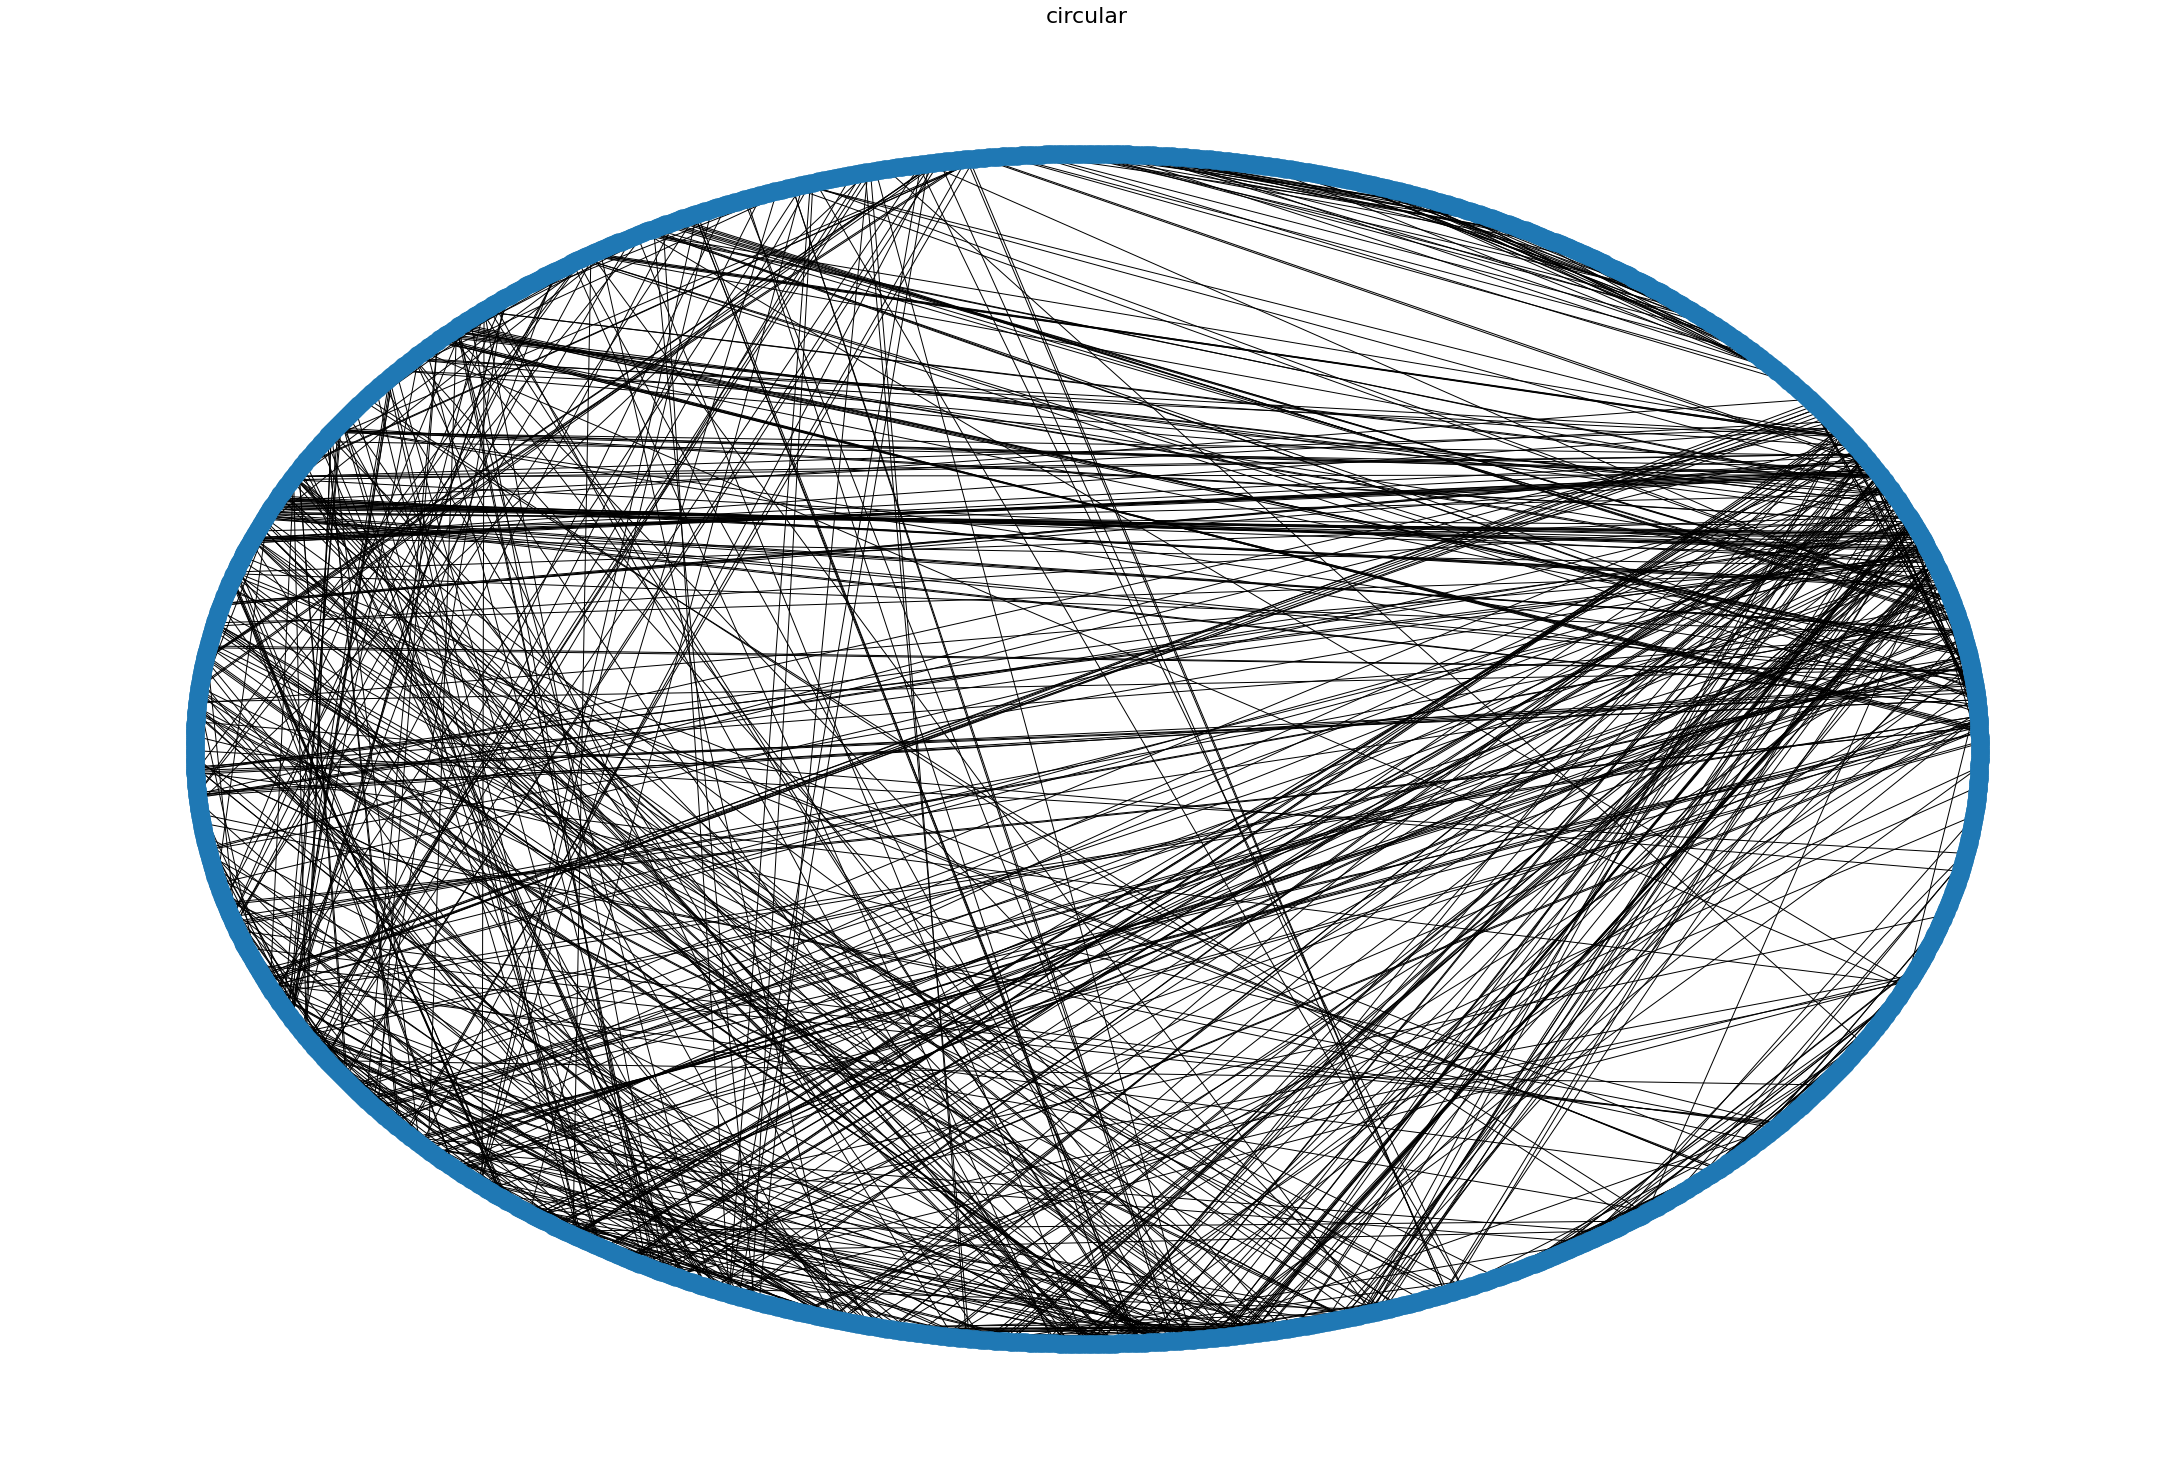

In [78]:
pos_kamada_kawai = nx.kamada_kawai_layout(G3)
pos_fruchterman_reingold = nx.fruchterman_reingold_layout(G3)
pos_circular = nx.circular_layout(G3)

layouts = {
    "kamada_kawai": pos_kamada_kawai,
    'fruchterman_reingold': pos_fruchterman_reingold,
    'circular': pos_circular,
}

for name, pos in layouts.items():
    plt.figure(figsize=(30, 20))
    nx.draw(G3, pos=pos, with_labels=False)
    plt.axis('off')
    plt.title(f"{name}", fontsize=22)
    plt.show()

# Bezpieczeństwo i odporność na awarie

Z jakiegoś powodu nasza sieć nie wykazuje spójności już na starcie. Ciężko będzie zatem mówić o momencie, w którym rozdzielamy sieć przez ataki na krawędzie czy wierzchołki. Mimo to możemy dalej porównywać ile krawędzi/wierzchołków trzeba usunąć, by jeszcze zwiększać ilość składowych. 

## Metryki kluczowe dla bezpieczeństwa w sieci

### Avg. vertex betweenness

In [81]:
avg_vertex_betweenness = run_measure(G3, measure='average_vertex_betweenness')
print("Average vertex betweenness:", avg_vertex_betweenness)

Average vertex betweenness: 16093.68


In [86]:
from graph_tiger.measures import diameter

print(f'Średnica grafu: {diameter(G3)}')

NetworkXError: Found infinite path length because the graph is not connected

In [84]:
from graph_tiger.measures import edge_connectivity

print(f'Minimalna liczba krawędzi, żeby rozdzielić główną składową: {edge_connectivity(G3)}')

Minimalna liczba krawędzi, żeby rozdzielić główną składową: 0


In [85]:
from graph_tiger.measures import avg_distance

print(f'Średnia długość ścieżki: {avg_distance(G3)}')

NetworkXError: Graph is not connected.

## Awarie i ataki

In [6]:
import os
import sys
import matplotlib.pyplot as plt

def plot_results(graph, steps, results, title):
   plt.figure(figsize=(6.4, 4.8))

   for method, result in results.items():
      result = [r / len(graph) for r in result]
      plt.plot(list(range(steps)), result, label=method)

   plt.ylim(0, 1)
   plt.ylabel('LCC')
   plt.xlabel('N_rm / N')
   plt.title(title)
   plt.legend()

   save_dir = os.getcwd() + '/plots/'
   os.makedirs(save_dir, exist_ok=True)

   plt.savefig(save_dir + title + '.pdf')
   plt.show()
   plt.clf()

In [16]:
from collections import defaultdict

from graph_tiger.attacks import Attack
from time import perf_counter

for steps in [100, 200, 400]:
    params = {
        'runs': 1,
        'steps': steps,
        'plot_transition': False,
        'gif_animation': False,
        'gif_snaps': False
    }

    print("Running node attacks")
    node_start = perf_counter()
    results = defaultdict(str)
    node_attacks = ['ib_node', 'id_node', 'rb_node', 'rd_node', 'rnd_node']
    for attack in node_attacks:
        params['attack'] = attack

        if 'rb' in attack or 'ib' in attack:
            params['attack_approx'] = int(0.05*len(G3))
        else:
            params['attack_approx'] = None

        a = Attack(G3, **params)
        results[attack] = a.run_simulation()
    node_stop = perf_counter()
    print(f'Node attacks ({steps} epochs, {len(node_attacks)} types) counting took: {node_stop - node_start:.3f}s')
    #plot_results(G3, params['steps'], results, title=f'WroJe-node-attacks_runs={params["runs"]}')


    print("Running edge attacks")
    edge_start = perf_counter()
    edge_attacks = ['ib_edge', 'id_edge', 'rb_edge', 'rd_edge', 'rnd_edge']
    results = defaultdict(str)
    for attack in edge_attacks:
        params['attack'] = attack

        if 'rb' in attack or 'ib' in attack:
            params['attack_approx'] = int(0.05*len(G3))
        else:
            params['attack_approx'] = None

        a = Attack(G3, **params)
        results[attack] = a.run_simulation()
    edge_stop = perf_counter()
    print(f'Edge attacks ({steps} epochs, {len(edge_attacks)} types) counting took: {edge_stop - edge_start:.3f}s')
    #plot_results(G3, params['steps'], results, title=f'WroJe-edge-attacks_runs={params["runs"]}')


Running node attacks
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Node attacks (100 epochs, 5 types) counting took: 167.650s
Running edge attacks
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Edge attacks (100 epochs, 5 types) counting took: 208.597s
Running node attacks
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Node attacks (200 epochs, 5 types) counting took: 302.414s
Running edge attacks
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Edge attacks (200 epochs, 5 types) counting took: 384.548s
Running node attacks
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running simulation 1 times
Running sim

KeyboardInterrupt: 

Creating example visualization
Running simulation 1 times


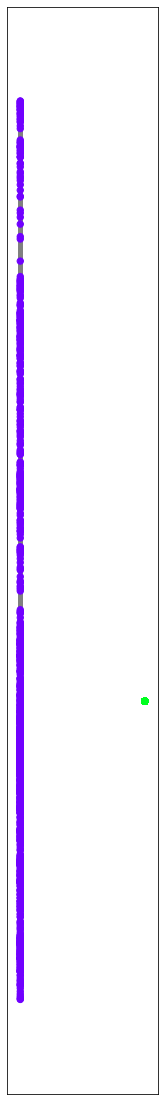

<Figure size 432x288 with 0 Axes>

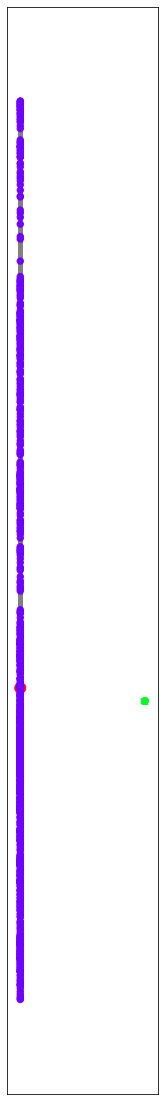

<Figure size 432x288 with 0 Axes>

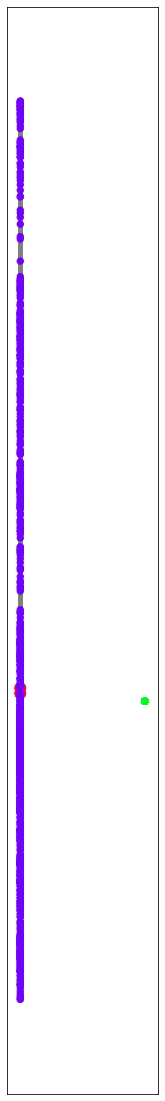

<Figure size 432x288 with 0 Axes>

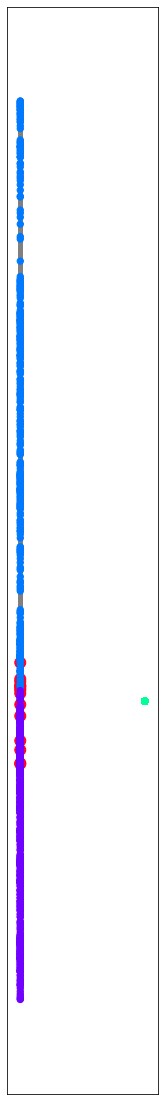

<Figure size 432x288 with 0 Axes>

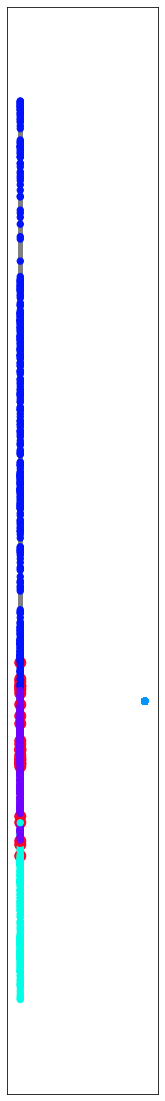

MovieWriter ffmpeg unavailable; using Pillow instead.


TypeError: __init__() got an unexpected keyword argument 'extra_args'

<Figure size 432x288 with 0 Axes>

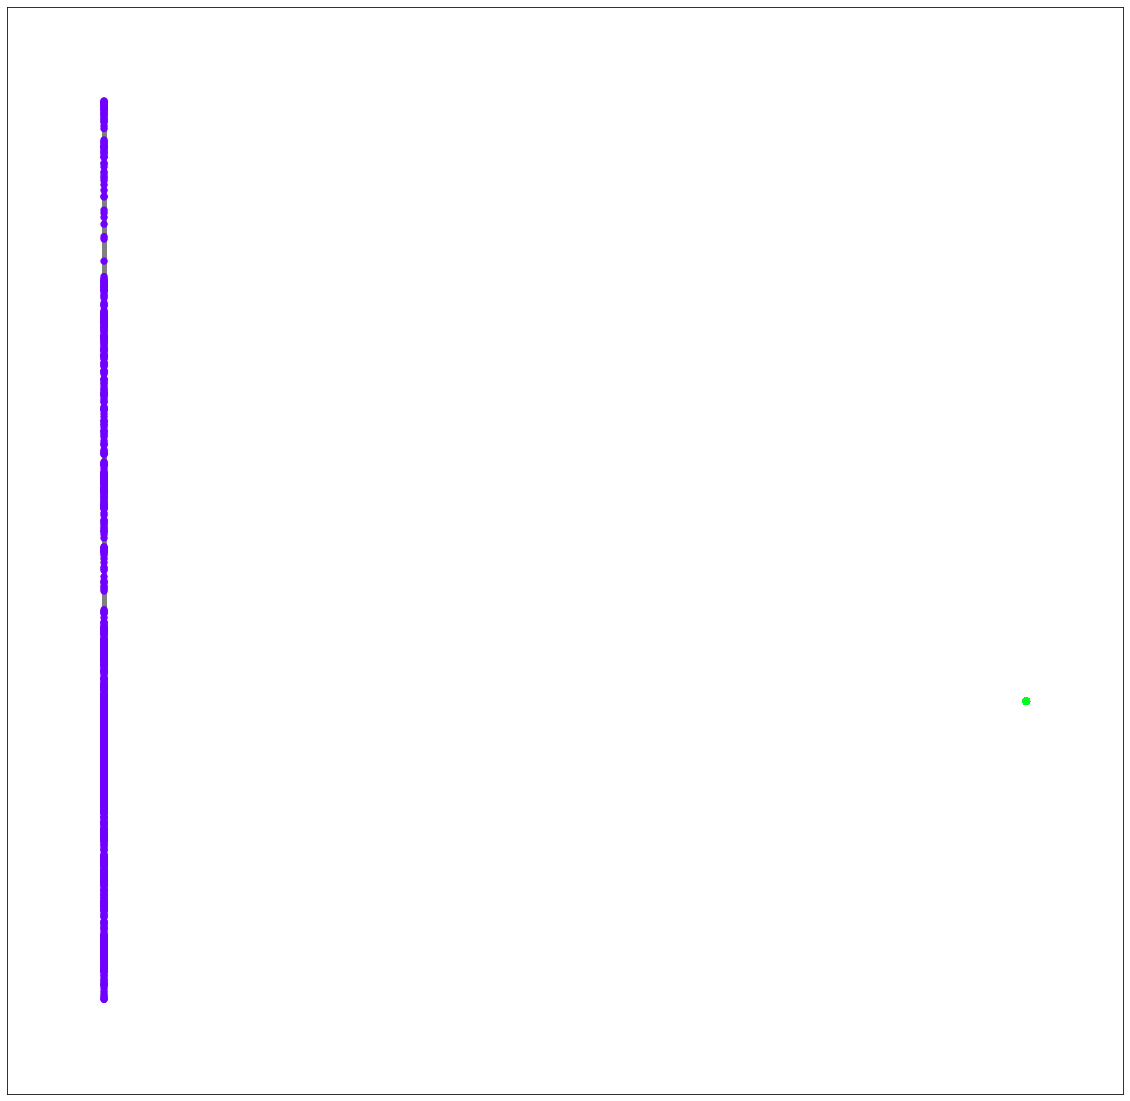

In [8]:
import os
import sys
import matplotlib.pyplot as plt
from collections import defaultdict

from graph_tiger.attacks import Attack
from graph_tiger.graphs import graph_loader

params = {
    'runs': 1,
    'steps': 30,
    'seed': 1,

    'attack': 'rb_node',
    'attack_approx': int(0.1*len(G3)),

    'plot_transition': False,
    'gif_animation': True,
    'gif_snaps': True,

    'edge_style': None,
    'node_style': None,
    'fa_iter': 20
}

print("Creating example visualization")
a = Attack(G3, **params)
a.run_simulation()